In [119]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import librosa
import IPython.display as ipd
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
from scipy.signal import butter, filtfilt

import warnings
warnings.filterwarnings('ignore')

In [161]:
filename = '../SampleWavFiles/piano_mix.wav'
audio, sr = librosa.load(filename)
num_sources = 3

print('Audio Shape:', audio.shape)
print('Sample Rate:', sr)

Audio Shape: (77014,)
Sample Rate: 22050


In [162]:
ipd.Audio(audio, rate=sr)

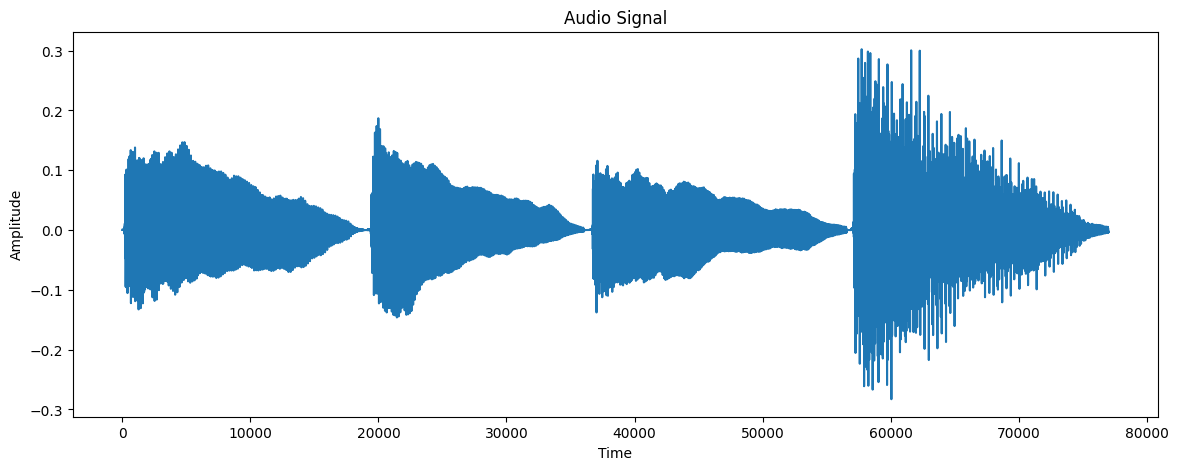

In [163]:
# Plot the audio signal
plt.figure(figsize=(14, 5))
plt.plot(audio)
plt.title('Audio Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [164]:
# apply a low-pass and high-pass filter to the audio signal
def butter_bandpass(lowcut, highcut, sr, order=5):
    nyq = 0.5 * sr
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [high], btype='lowpass')
    return b, a

def butter_bandpass_filter(audio, lowcut, highcut, sr, order=5):
    b, a = butter_bandpass(lowcut, highcut, sr, order=order)
    y = filtfilt(b, a, audio)
    return y

# apply the filter to the audio signal
# audio = butter_bandpass_filter(audio, 100, 1000, sr)

# # Plot the audio signal
# plt.figure(figsize=(14, 5))
# plt.plot(audio)
# plt.title('Audio Signal')
# plt.xlabel('Time')
# plt.ylabel('Amplitude')
# plt.show()

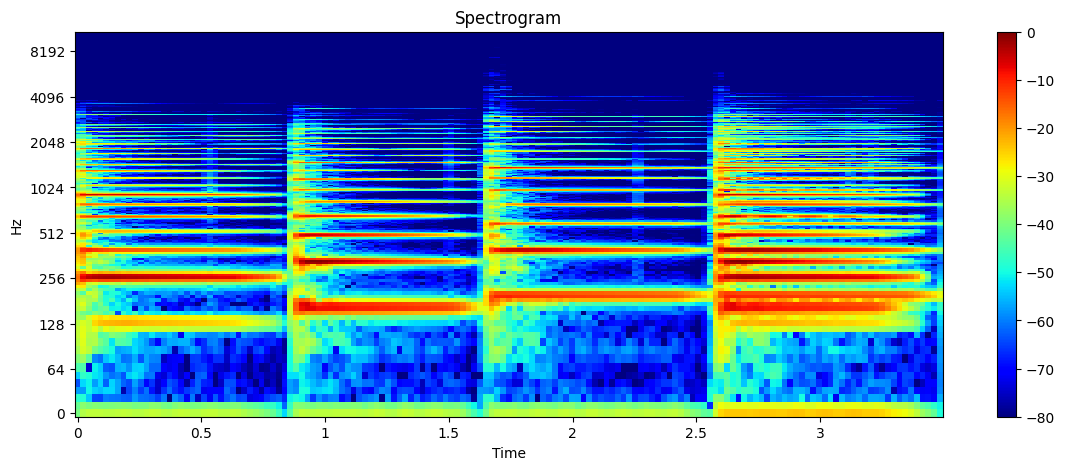

In [165]:
# Plot the spectrogram
X = librosa.stft(audio)
Xdb = librosa.amplitude_to_db(abs(X), ref=np.max)
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis ='time', y_axis='log', cmap= matplotlib.cm.jet)
plt.colorbar()
plt.title('Spectrogram')
plt.show()

In [166]:
# Get magnitude and phase of the signal
mag, phase = librosa.magphase(X)

# Perform ICA
n_components = num_sources
ica = FastICA(n_components=n_components)
S_ = ica.fit_transform(mag.T)
A_ = ica.mixing_

print('Shape of S_: ', S_.shape)
print('Shape of A_: ', A_.shape)

Shape of S_:  (151, 3)
Shape of A_:  (1025, 3)


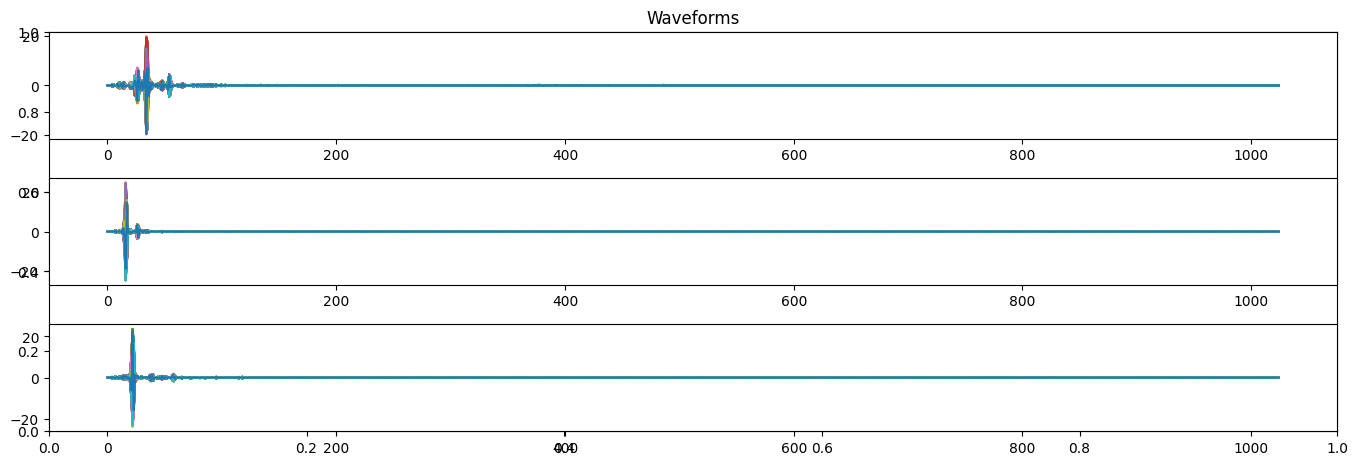

In [167]:
# Plot the waveforms
plt.figure(figsize=(14, 5))
plt.title('Waveforms')
for i in range(n_components):
    plt.subplot(n_components, 1, i+1)
    Y = np.zeros_like(X)
    Y = S[:, i, np.newaxis] * phase
    plt.plot(Y)
plt.tight_layout()
plt.show()

In [168]:
reconstructed_components = []
for i in range(n_components):
    Y = np.zeros_like(X)
    Y = S[:, i, np.newaxis] * phase
    y = librosa.istft(Y)
    y = butter_bandpass_filter(y, 100, 1000, sr)
    reconstructed_components.append(y)

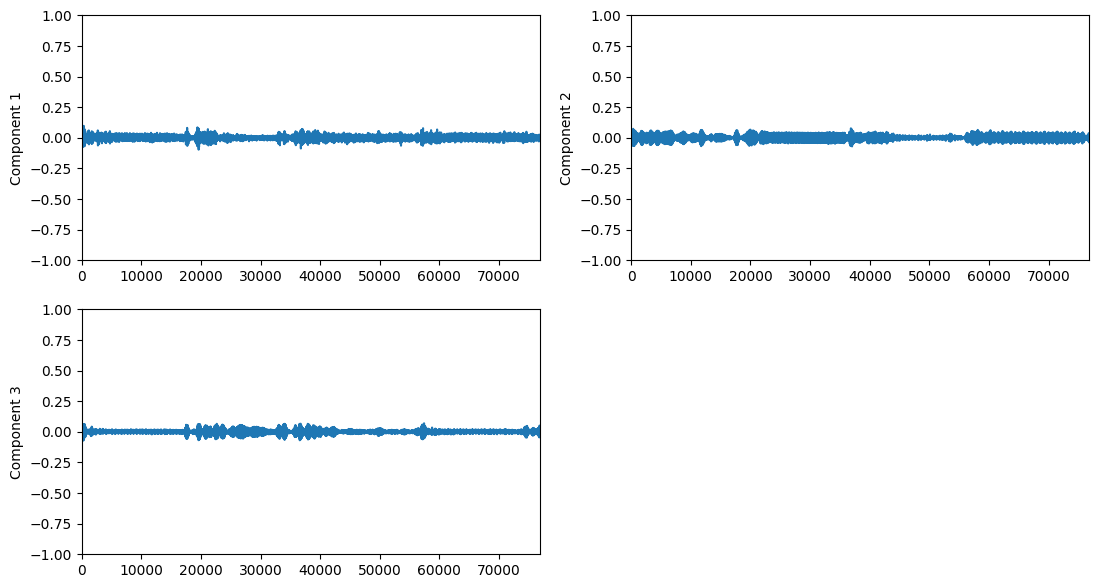

In [169]:
# display all the components
plt.figure(figsize=(13, 7))
for n in range(n_components):
    plt.subplot(int(np.ceil(n_components / 2)), 2, n + 1)
    plt.plot(reconstructed_components[n])
    plt.ylim(-1, 1)
    plt.xlim(0, reconstructed_components[n].shape[0])
    plt.ylabel(f'Component {n + 1}')

plt.show()

In [170]:
# play each reconstructed component
for i in range(n_components):
    ipd.display(ipd.Audio(reconstructed_components[i], rate=sr))

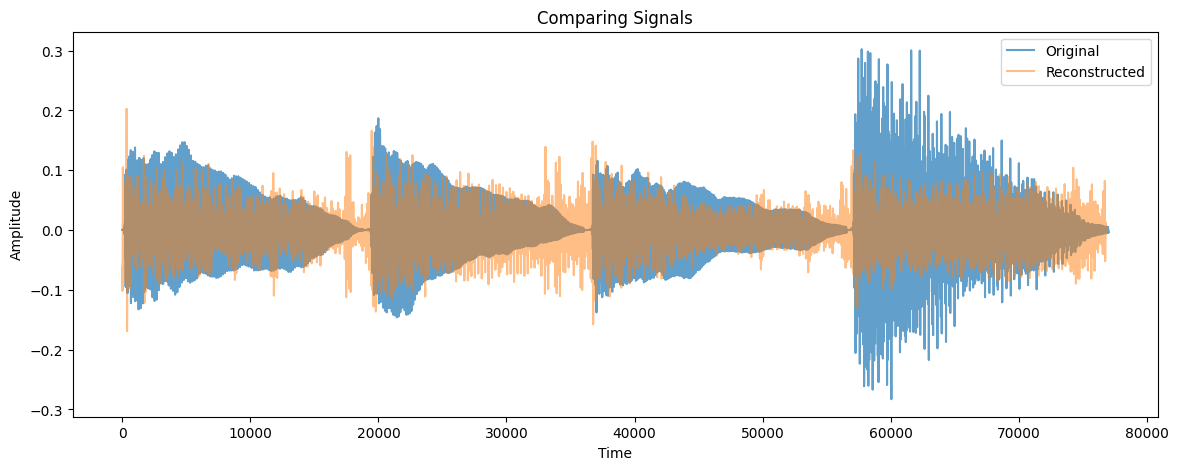

In [171]:
# Combine the components into a single signal.
reconstructed_signal = np.sum(reconstructed_components, axis=0)

# plot the reconstructed signal and the original signal
plt.figure(figsize=(14, 5))
plt.plot(audio, label='Original', alpha=0.7)
plt.plot(reconstructed_signal, label='Reconstructed', alpha=0.5)
plt.title('Comparing Signals')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [172]:
# play the original signal
print('Original Signal')
ipd.display(ipd.Audio(audio, rate=sr))

# play the reconstructed signal
print('Reconstructed Signal')
ipd.display(ipd.Audio(reconstructed_signal, rate=sr))

Original Signal


Reconstructed Signal
